# fastbook 04_mnist_basics
> not done

- toc:false
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [MNIST]

ref: https://github.com/fastai/fastbook

In [2]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

## Introduction

- We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically.
- We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches.
- We'll also describe the math that a basic neural network is actually doing.
- Finally, we'll put all these pieces together.

## End sidebar

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
Path.BASE_PATH = path

In [7]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [9]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

Let's take a look in one of these folders (using sorted to ensure we all get the same order of file

In [12]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [13]:
im3_path=threes[1]
im3=Image.open(im3_path)
im3

Here we are using the *Image* class from the *Python Imaging Library (PIL)*, which is the most widely used Python package for opening, manipulating, and viewing images.

In [16]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image.

Here's the same thing as a PyTorch tensor:

In [18]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [20]:
im3_t=tensor(im3)
df=pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- You can see that the background **white pixels are stored as the number 0**, **black is the number 255**, and **shades of gray are between the two**. 
-  The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

## Pixel Similarity

In [23]:
array(im3)[4:10,4:10]/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11372549],
       [0.        , 0.        , 0.        , 0.18823529, 0.65098039,
        0.87843137],
       [0.        , 0.36470588, 0.95686275, 0.97647059, 0.99215686,
        0.73333333],
       [0.        , 0.41960784, 0.99215686, 0.99215686, 0.90196078,
        0.18823529],
       [0.        , 0.01176471, 0.07843137, 0.07843137, 0.05882353,
        0.        ]])

In [26]:
three_tensors=[tensor(Image.open(i)) for i in threes]
seven_tensors=[tensor(Image.open(i)) for i in sevens]

In [27]:
len(three_tensors),len(seven_tensors)

(6131, 6265)

Since we now *have tensors* (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:`

<AxesSubplot:>

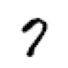

In [33]:
show_image(seven_tensors[3])

- For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 
    - 모든 픽셀 위치에서 해당 픽셀 강도의 모든 이미지에 대한 평균을 계산하기 위해서 
- To do this we first combine all the images in this list into a single three-dimensional tensor. 
    - 우선 이 리스트의 모든 이미지를 단일 3차원 텐서로 결합한다.
- The most common way to describe such a tensor is to call it a rank-3 tensor. 
- We often need to stack up individual tensors in a collection into a single tensor. 

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [34]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

In [37]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width

In [39]:
len(stacked_sevens.shape)

3

> important: rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor.

We can also get a tensor's rank directly with ndim:

In [40]:
stacked_sevens.ndim

3

for every pixel position, this will compute the average of that pixel over all images. 

The result will be one value for every pixel position, or a single image. Here it is:

<AxesSubplot:>

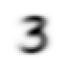

In [46]:
mean3=stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

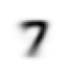

In [47]:
mean7=stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

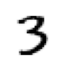

In [48]:
a_3 = stacked_threes[1]
show_image(a_3)

<AxesSubplot:>

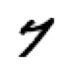

In [49]:
a_7 = stacked_sevens[1]
show_image(a_7)

<AxesSubplot:>

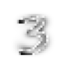

In [53]:
show_image(abs(a_3-mean3))

- We can't just add up the differences between the pixels of this image and the ideal digit. 
- Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.
- That would be misleading!

1. Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or L1 norm
2. Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the root mean *squared error (RMSE)* or L2 norm.

In [55]:
dist_3_abs=(a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [56]:
dist_7_abs=(a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1304), tensor(0.2585))

- In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. 
- So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [57]:
F.l1_loss(a_3.float(),mean7),F.mse_loss(a_3.float(),mean7)

(tensor(0.1586), tensor(0.0913))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).